In [ ]:
## Uncomment this cell to download requirements.
# !pip install -q efficientnet_pytorch 
# !pip install albumentations==0.4.6

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [ ]:
# Importing required libraries
import numpy as np
import pandas as pd
import cv2
import os, os.path
from PIL import Image
from numpy import pi                
from numpy import r_                
import scipy     
from sklearn.model_selection import train_test_split
from scipy import fftpack           
import random
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg  
%matplotlib inline
from tqdm.notebook import tqdm 
from sklearn.model_selection import KFold
from sklearn import metrics
import torch
import torch.nn as nn
import torch.optim as optim
from torch import FloatTensor, LongTensor
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F

from albumentations import (ToFloat, Normalize, VerticalFlip, HorizontalFlip, Compose, Resize,
                            RandomBrightness, RandomContrast, HueSaturationValue, Blur, GaussNoise)
from albumentations.pytorch import ToTensorV2, ToTensor
from efficientnet_pytorch import EfficientNet
from torchvision.models import resnet34

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# EDA of Alaska2 Dataset
# this code is written on our own
root_dir = '../input/alaska2-image-steganalysis/'

def path_read(dir):
  paths = pd.Series(os.listdir(root_dir+dir))
  return pd.Series(root_dir+dir+'/'+paths)

cover_paths = np.array(path_read("Cover"))
juni_paths = np.array(path_read("JUNIWARD"))
test_paths = np.array(path_read("Test"))
print(cover_paths.size)

75000


In [ ]:
seed = 1234
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
os.environ['PYTHONHASHSEED'] = str(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())

cuda
Tesla P100-PCIE-16GB


In [ ]:
# THis code was writen taking reference from 
# https://www.kaggle.com/code/shonenkov/train-inference-gpu-baseline
# https://www.kaggle.com/code/kingkongs7/alaska2-efficient
# https://www.kaggle.com/code/khoongweihao/alaska2-blending-efficientnets-on-tpus
# https://github.com/romavlasov/alaska2-image-steganalysis
# https://github.com/RishiMalhotra920/Image-Steganalysis
# https://www.kaggle.com/code/mahmudds/alaska2-image-eda-understanding-and-modeling


class CreateDataset(Dataset):
  def __init__(self, df, type_ = 'train', flip = (0.5,0.5)):
    self.df, self.type_, self.flip = df, type_, flip
    if self.type_ == "train":
      self.transform = Compose([Resize(512, 512), 
                                      VerticalFlip(p = flip[0]),
                                      HorizontalFlip(p = flip[1]),
                                      Normalize(),
                                      ToFloat(max_value=255),
                                      ToTensor()])  
    else:
      self.transform = Compose([Resize(512, 512), 
                                      Normalize(),
                                      ToFloat(max_value=255),
                                      ToTensor()])
  
  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    if self.type_ == "test":
      path = self.df.loc[index][0]
    else:
      path, label = self.df.loc[index]
#     print("idx: ",index)
    im = cv2.imread(path)[:,:,::-1]
    im = self.transform(image=im)
    image = im['image']

    if self.type_=="test":
      return image
    else:
      return image, label

In [ ]:
def createdf(paths, labels = None, istest = False):
  
  if istest:
    data = paths
    df = pd.DataFrame(data,columns = ["path"])
  else:
    data = np.concatenate([paths, labels]).reshape((2,labels.size)).T
    df = pd.DataFrame(data,columns = ["path","label"])
  return df


In [ ]:
cover = cover_paths[:1400]
juni = juni_paths[:1400]
train_paths = np.concatenate([cover,juni])
labels = np.array([0]*len(cover)+[1]*len(juni))
df = createdf(train_paths, labels)
train_df, val_df = train_test_split(df, test_size=0.3, random_state=seed, shuffle=True)
train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)
# print(train_df)

test_path = test_paths[:100]
test_df = createdf(test_path,istest = True)
# test_df

In [ ]:
# cover = cover_paths[70:140]
# juni = juni_paths[70:140]
# valid_paths = np.concatenate([cover,juni])
# val_labels = np.array([0]*len(cover)+[1]*len(juni))
# val_df = createdf(valid_paths, val_labels)
print(train_df)

                                                   path label
0     ../input/alaska2-image-steganalysis/JUNIWARD/2...     1
1     ../input/alaska2-image-steganalysis/Cover/4393...     0
2     ../input/alaska2-image-steganalysis/JUNIWARD/4...     1
3     ../input/alaska2-image-steganalysis/Cover/7713...     0
4     ../input/alaska2-image-steganalysis/JUNIWARD/6...     1
...                                                 ...   ...
1955  ../input/alaska2-image-steganalysis/JUNIWARD/2...     1
1956  ../input/alaska2-image-steganalysis/JUNIWARD/4...     1
1957  ../input/alaska2-image-steganalysis/Cover/1965...     0
1958  ../input/alaska2-image-steganalysis/Cover/2112...     0
1959  ../input/alaska2-image-steganalysis/Cover/6272...     0

[1960 rows x 2 columns]


In [ ]:
# cover = cover_paths[:7]
# juni = juni_paths[:7]
# train_paths = np.concatenate([cover,juni])
# labels = np.array([0]*len(cover)+[1]*len(juni))
# train_data = np.concatenate([train_paths, labels]).reshape((2,labels.size)).T
# print(train_data)
# train_df = pd.DataFrame(train_data,columns = ["path","label"])
# train_df

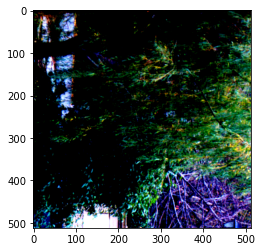

In [ ]:
training_data = CreateDataset(train_df,'train')
plt.imshow((training_data[0][0]*255).T,cmap='gray')

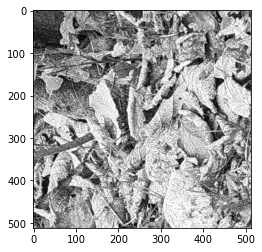

In [ ]:
test_data = CreateDataset(test_df, 'test')
plt.imshow((test_data[0][0]*255).T,cmap='gray')


In [ ]:
val_data = CreateDataset(val_df,'val')

In [ ]:
# SRNet Model
# This code is written by us
from torch import nn
from torch import Tensor

class Convlayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x
    
class ResidualBlock1(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = Convlayer(in_channels, out_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        res = x
        x = self.conv1(x)
        x = self.relu(x)
        # x += res
        return x
    
class ResidualBlock2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = ResidualBlock1(in_channels, out_channels)
        self.conv2 = Convlayer(out_channels, out_channels)
        
    def forward(self, x):
        res = x
        x = self.conv1(x)
        x = self.conv2(x)
        x += res
        return x

class ResidualBlock3(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 2, padding = 1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.conv1 = ResidualBlock1(in_channels, out_channels)
        self.conv2 = Convlayer(out_channels, out_channels)
        self.avgpool = nn.AvgPool2d(kernel_size = 2, stride = 2)
        
    def forward(self, x):
        res = self.conv(x)
        res = self.bn(res)
        res = self.avgpool(res)
        x = self.conv1(x)
        x = self.conv2(x)
        x += res
        return x
    
class ResidualBlock4(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = ResidualBlock1(in_channels, out_channels)
        self.conv2 = Convlayer(out_channels, out_channels)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        
    def forward(self, x):
        res = x
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.avgpool(x)
        # x += res
        return x

class SRNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            ResidualBlock1(3, 64),
            ResidualBlock1(64, 64),
            ResidualBlock1(64, 16)
        )
        self.layer2 = nn.Sequential(
            ResidualBlock2(16, 16),
            ResidualBlock2(16, 16),
            ResidualBlock2(16, 16)
        )
        self.layer3 = nn.Sequential(
            ResidualBlock3(16, 32),
            ResidualBlock3(32, 64),
            ResidualBlock3(64, 128),
            ResidualBlock3(128, 256)
        )
        self.layer4 = ResidualBlock4(256, 512)
        self.lin = nn.Linear(512, 2)
        self.logsoftmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # print(x.shape)
        x = self.layer4(x)
        # print(x.shape)
        x = x.view(x.shape[0], -1)
        # print(x.shape)
        x = self.lin(x)
        x = self.logsoftmax(x)
        return x

In [ ]:
# EfficientNet Model
class EfficientNetModel(nn.Module):
    def __init__(self, num_classes=2, type_ = 0):
        super().__init__()
        modelname = 'efficientnet-b'+str(type_)
        self.effnet = EfficientNet.from_pretrained(modelname)
        self.dropout = nn.Dropout(0.1)
        arr = [1280, 1280, 1408, 1536, 1792]
        self.out = nn.Linear(arr[type_], num_classes)
    
    def forward(self, image):
        batch_size, _, _, _ = image.shape
        x = self.effnet.extract_features(image)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch_size, -1)
        x = self.dropout(x)
        out = self.out(x)
        return out

In [ ]:
model = EfficientNetModel(type_ = 2)#.to(device)
# model = model.cuda()

Loaded pretrained weights for efficientnet-b2


In [ ]:
# THis part of code is the dataloader
dataloader = DataLoader(training_data, batch_size=2, shuffle=True)
for x, y in dataloader:
    out = model(x)
    print(out)
    print(y)
    loss = nn.CrossEntropyLoss()(out, y)
    print(loss)
    break



tensor([[ 0.0190, -0.1090],
        [-0.1071,  0.0921]], grad_fn=<AddmmBackward>)
tensor([1, 0])
tensor(0.7784, grad_fn=<NllLossBackward>)


In [ ]:
# This code was taken from https://www.kaggle.com/code/mahmudds/alaska2-image-eda-understanding-and-modeling




def Data_weighted_auc(y, y1):
    thresh = [0,0.4,1]
    w = [2,1]
    falsepr, truepr, threshold = metrics.roc_curve(y, y1)
    area = np.array(thresh[1:]) - np.array(thresh[:-1])
    normconst = np.dot(w, area)
    m = 0
    for idx, weight in enumerate(w):
        ymin = thresh[idx]
        ymax = thresh[idx+1]
        mask = (ymin < falsepr) & (falsepr <= ymax)
        xpadded = np.linspace(falsepr[mask][-1], 1, 100)
        x = np.concatenate([falsepr[mask], xpadded])
        y = np.concatenate([truepr[mask], [ymax]*len(xpadded)])
        y -= ymin
        scores = metrics.auc(x, y)
        submetric = scores * weight
        best = (ymax - ymin)*weight
        m += submetric
    
    return m/normconst

In [ ]:
# This code was refered from the following notebooks
# https://www.kaggle.com/code/shonenkov/train-inference-gpu-baseline
# https://www.kaggle.com/code/kingkongs7/alaska2-efficient
# https://www.kaggle.com/code/khoongweihao/alaska2-blending-efficientnets-on-tpus
# https://github.com/romavlasov/alaska2-image-steganalysis
# https://github.com/RishiMalhotra920/Image-Steganalysis
# https://www.kaggle.com/code/mahmudds/alaska2-image-eda-understanding-and-modeling

def train(model, num_epochs, batch_size, num_workers, lr, weight_decay):
    best = None
    train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    loss = nn.CrossEntropyLoss()
    optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=3, verbose=True, factor=0.5)
    
    train_loss = []
    eval_loss = []
    
    for epoch in range(num_epochs):
        model.train()
        
        trainloss = 0
        
        for im, label in train_loader:
            optim.zero_grad()
            im = im.to(device)
            label = label.to(device)
            out = model(im)
            l = loss(out, label)
            trainloss += l.item()
            l.backward()
            optim.step()
            
            trainloss += l.item()
        train_loss.append(trainloss/batch_size)
        

        model.eval()
        evalloss = 0
        true = []
        pred = []
        
        with torch.no_grad():
#             print("Yes")
            for im, label in val_loader:
                im = im.to(device)
                label = label.to(device)
                out = model(im)
                l = loss(out, label)
                true.extend(label.cpu().numpy().astype(int))
                pred.extend(F.softmax(out, dim=1).cpu().numpy())
                
                evalloss += l.item()
                
        eval_loss.append(evalloss/batch_size)
        
        pred = np.array(pred)    
        # pred_ = np.where(pred>0.5, 1, 0)
#         print(pred)
        pred_ = pred.argmax(1)
        
        acc = (pred_ == true).mean()
        
        new_pred = np.zeros(len(pred))
        temp = pred[pred_!=0,1:]
        new_pred[pred_!=0] = temp.sum(1)
        new_pred[pred_==0] = 1-pred[pred_==0,0]
        
        true = np.array(true)
        true[true!=0] = 1
        
        score = Data_weighted_auc(true, new_pred)
        
        print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {trainloss/batch_size} | Eval Loss: {evalloss/batch_size} | Acc: {acc} | Score: {score}')
        scheduler.step(score)
        if best==None:
            best = score
            torch.save(model.state_dict(), f'./Epoch_{epoch+1}ValLoss{eval_loss[epoch]:.3f}AUC.pth')
            continue

        
    plt.plot(train_loss, label='Train Loss')
    plt.plot(eval_loss, label='Eval Loss')
    plt.legend()
    plt.show()
        
        

In [ ]:
epochs = 10
batch_size = 16 #32
num_workers = 4
l_r = 0.01
weight_decay = 0.00001
plot_loss = True #False

In [ ]:
model = model.to(device)

Epoch 1/10 | Train Loss: 10.963813737034798 | Eval Loss: 3.7419234924018383 | Acc: 0.48214285714285715 | Score: 0.5880597620061222
Epoch 2/10 | Train Loss: 10.780112616717815 | Eval Loss: 2.306793835014105 | Acc: 0.5178571428571429 | Score: 0.5911471953617548
Epoch 3/10 | Train Loss: 10.80504248291254 | Eval Loss: 2.3881027661263943 | Acc: 0.5178571428571429 | Score: 0.5688175312696385
Epoch 4/10 | Train Loss: 10.850857853889465 | Eval Loss: 6.188527081161737 | Acc: 0.4976190476190476 | Score: 0.5883374891037726
Epoch 5/10 | Train Loss: 10.781605087220669 | Eval Loss: 2.6226301789283752 | Acc: 0.48214285714285715 | Score: 0.5975693810942853
Epoch 6/10 | Train Loss: 10.786652870476246 | Eval Loss: 2.4526204615831375 | Acc: 0.48214285714285715 | Score: 0.6017008250724727
Epoch 7/10 | Train Loss: 10.752527371048927 | Eval Loss: 2.2964806519448757 | Acc: 0.48214285714285715 | Score: 0.6819903099596587
Epoch     6: reducing learning rate of group 0 to 5.0000e-03.
Epoch 8/10 | Train Loss: 10

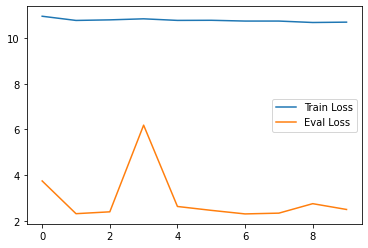

In [ ]:
train(model, epochs, batch_size, num_workers, l_r, weight_decay, plot_loss)

In [ ]:
# Saving model
torch.save(model.state_dict(), './pkl.pth')